In [1]:
import pickle
import pandas as pd
import re
from matplotlib import pyplot as plt
import nltk
import string
import itertools
import seaborn as sns

In [2]:
cr_df = pd.read_pickle('../pickle_jar/CritRole_split.pkl')
cr_df['text'] = cr_df['text'].str.replace(r'♫', r'', regex=True).astype('str')
cr_df = cr_df.rename(columns={'text': 'speech_turn'})
cr_df=cr_df.drop(321664) #another full produced song (not them singing at the table) skewing the sent length data badly
cr_df=cr_df.drop(78020)  #a badly coded line (spit out some meta info it looks like) skewing word len data
cr_df

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,
1,1,LAURA,As in nnnn.,1,00:01:21,,
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises)
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,
...,...,...,...,...,...,...,...
434047,2722,MATT,"We're going to get through this together, guys.",99,03:47:47,,
434048,2723,SAM,Wash your stubbly face.,99,03:47:49,,
434049,2724,TRAVIS,Gross.,99,03:47:51,,
434050,2725,MATT,,99,03:47:52,,(cheering)


In [3]:
#found some name misspellings and some (confirmed) sporadic useage of character names instead of player names, but very few (weird)
cr_df['name'] = cr_df['name'].str.replace(r'MTT', r'MATT', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'AMTT', r'MATT', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'NOTT', r'SAM', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'CALEB', r'LIAM', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'BEAU', r'MARISHA', regex=True).astype('str')
cr_df['name'] = cr_df['name'].str.replace(r'JESTER', r'MATT', regex=True).astype('str')

# Table of Contents 

### Part 1

1. [Counting Lines](#Counting-Lines)
    - [Exploring Results](#Exploring-Results)<br>
    <br>
2. [Adding new columns](#Adding-new-columns)
    - [Word Counts](#Word-counts-(per-line))
    - [Words per speaker](#Total-words-per-speaker)
    - [Unique words per speaker](#Unique-words-per-speaker)
    - [Word Length](#Word-Length)
    - [Sentences and sentence length](#Sentences-and-sentence-length)<br>
<br>   
3. [Initial Conlusions](#Initial-Conlusions)

### Part 2

1. [Dividing the data by group](#Dividing-the-data-by-group)

## Counting Lines

First thing's first, let's just see how many lines each speaker has as a basis to go off of for the rest of our research.

The problem I had initially was counting *all* lines associated per name, including lines in the 'speech turn' column that are empty because the value had been moved to the 'nonspeech' or 'inaudible' columns instead. To combat this, I've selected only the name and text columns and dropped any row from the text column that contains no text. By doing this we've eliminated 11,474 lines from the text volume that have no value.

In [4]:
lcount = cr_df[['name', 'speech_turn']].copy() #copy just these two cols over for now
lcount = lcount[lcount['speech_turn'] != '']  #drop any rows without any value

In [5]:
spcount = pd.DataFrame(lcount.groupby(['name'])['speech_turn'].count())
spcount = spcount.reset_index()
spcount = spcount.sort_values('speech_turn', ascending=False)
spcount.head(n=8)

,name,speech_turn
200,MATT,109579
104,LAURA,58407
245,SAM,50447
168,MARISHA,48138
316,TRAVIS,48073
136,LIAM,40254
293,TALIESIN,39736
14,ASHLEY,17166


So here are the line counts per main cast member! Very interesting stuff. Predictably, Matt talks a *lot* more than every other participant, almost twice as much as the second most lines spoken.

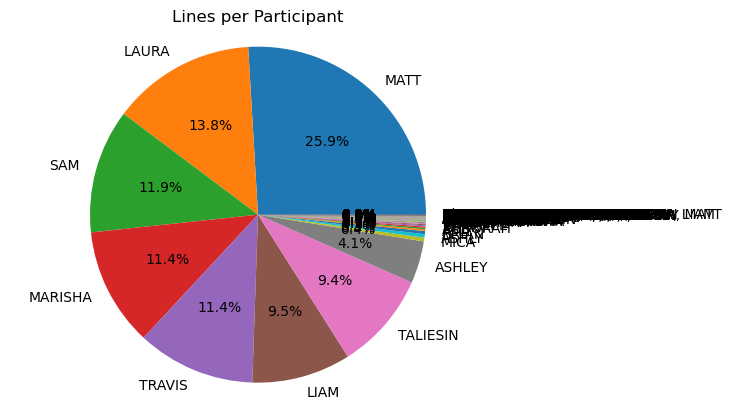

In [6]:
plt.pie(spcount['speech_turn'], labels=spcount['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Lines per Participant')
plt.show()

## Exploring Results

First of all, there is some important information to add some context to the information we're looking at. 

#### 1
First thing is attendance. The fan-run website [CritRole Stats](https://www.critrolestats.com/stats) tracks a number of statistics for each episode of Critical Role. The one we're looking at is Campaign 2 (Mighty Nein Campaign). They have very helpfully included attendance among their stats!<br>
Not every player was present for every single episode. Laura and Travis left for some time for parental leave, Taliesin had a character death, and Ashley was away for a time filming for a television show. This show spanned multiple years, Jan 2018 to June 2021, on a weekly basis except for a period from March to July 2020 for quarantine. It's not odd to have someone have to miss an episode sometimes.

Here is the attendance list by CR Stats:<br>
Matt      -> 141<br>
Marisha	  -> 141<br>
Sam	      -> 141<br>
Liam	  -> 140<br>
Taliesin  -> 139<br>
Travis	  -> 136<br>
Laura	  -> 133<br>
Ashley	  -> 86

Interestingly, this explains why Ashley has as few lines as she does, but otherwise there is not a 1:1 match of attendance to how much a player spoke.

#### 2
Another thing to consider is characters. Laura may have been in the second to least episodes out of the full cast, but her character, Jester, is an excitable motormouth. Marisha and Travis, on the other hand, play slightly more serious characters , and Liam, Ashley, and Taliesin (from episode 30-ish onward) play more stoic types. 

#### 3
Finally, roles. At the top of each episode (or most of them, at least), two things happen. Sam reads ads for the show, often making them into skits or scripts full of jokes and siliness. Then, often, Laura updates viewers on new merch added to their store, what's available, what's coming and when it'll be available, and so on. It wouldn't be surprising to find that this affects their speech totals by a good bit.

Since I spent so long crafting that nonspeech column let's take a look at its values just to see what we see. 

In [7]:
allsounds = cr_df['nonspeech'].value_counts()
allsounds[:15]

                408173
(laughter)        6163
(laughs)          1933
(laughs)           874
(laughter)         720
(whispering)       416
(cheering)         338
(gasps)            293
(gasps)            281
(singing)          278
(sighs)            273
(groaning)         254
(counting)         242
(sighs)            195
(groans)           174
Name: nonspeech, dtype: int64

In [8]:
scount = cr_df[['name', 'nonspeech']].copy()
scount = scount[scount['nonspeech'] != '']
nscount = pd.DataFrame(scount.groupby(['name'])['nonspeech'].count())
nscount = nscount.reset_index()
nscount = nscount.sort_values('nonspeech', ascending=False)
nscount.head(n=8)

,name,nonspeech
92,MATT,7176
142,TRAVIS,3801
49,LAURA,3311
115,SAM,3265
77,MARISHA,2451
61,LIAM,2393
134,TALIESIN,1341
10,ASHLEY,1005


Not extremely important since it's not part of speech analysis but I put the work in and I wanted to see it.
Not surprising again! Matt being the first makes sense, he is known as a DM for including sound effects (and being very good at them). Just a cool stat... moving on!

## Adding new columns

Tokenizing (should we tokenize including punctuation in this case...?), token counts & averages, word types (which will be shared) (checkw ith na rae.... word types are deemed ok for the FULL text or line by line?), sentence count, sentence length.

### Word counts (per line)

In [9]:
punctuations="!@#$%^&*()_-=+:;{}[]<>,.?/\''"

In [10]:
tokens = cr_df.speech_turn.map(nltk.word_tokenize)
tokens

0         [We, 've, got, some, cool, stuff, to, talk, ab...
1                                         [As, in, nnnn, .]
2         [Nnnn, ., But, yeah, ,, so, they, 're, going, ...
3                               [Would, you, like, some, ?]
4         [So, yeah, ., I, 'm, super, excited, to, have,...
                                ...                        
434047    [We, 're, going, to, get, through, this, toget...
434048                       [Wash, your, stubbly, face, .]
434049                                           [Gross, .]
434050                                                   []
434051                                                   []
Name: speech_turn, Length: 434050, dtype: object

In [11]:
cr_df['tokens']=tokens         #create token column
cr_df['nopunc']=cr_df['tokens'].apply(lambda tokens: [w for w in tokens if w not in punctuations]) #list comprehend to remove toks
cr_df = cr_df.drop('tokens', axis=1)     #drop that toks col, we don't actually want it

In [12]:
cr_df['word_count'] = cr_df.nopunc.map(len)   #count total tokens per line
cr_df.head() #pre punc removal index 0 had 179 words, so this worked pretty well for accuracy

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech,nopunc,word_count
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,"[We, 've, got, some, cool, stuff, to, talk, ab...",155
1,1,LAURA,As in nnnn.,1,00:01:21,,,"[As, in, nnnn]",3
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,"[Nnnn, But, yeah, so, they, 're, going, to, be...",122
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),"[Would, you, like, some]",4
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,"[So, yeah, I, 'm, super, excited, to, have, th...",129


So we know who has the most speech events (Matt) but what about who says the most words? Someone with fewer speech events (lines) could have one very very long speech, who knows

### Total words per speaker

In [13]:
wcount = pd.DataFrame(cr_df.groupby('name').word_count.sum())
wcount = wcount.reset_index()
wcount = wcount.sort_values('word_count', ascending=False)
wcount.head(n=8)

,name,word_count
211,MATT,1385768
112,LAURA,427517
260,SAM,355003
144,LIAM,343809
337,TRAVIS,339729
176,MARISHA,334941
312,TALIESIN,311166
16,ASHLEY,103511


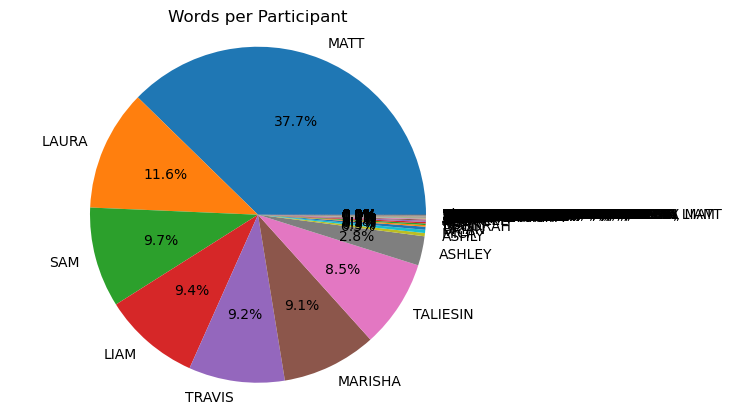

In [14]:
plt.pie(wcount['word_count'], labels=wcount['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Words per Participant')
plt.show()

bla lbhalbnhalb only travis and marisha trade places means he says just a little more
not only is Matt talking more, he's *saying* more.

### Unique words per speaker

In [15]:
cr_df['types'] = cr_df['nopunc'].apply(lambda tokens: [w.lower() for w in tokens])

In [16]:
cr_df['types'] = cr_df['types'].apply(set)

In [17]:
cr_df['type_count'] = cr_df.types.map(len) 
cr_df.head() #again to confirm, before punc removal type count for index 0 was 95

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech,nopunc,word_count,types,type_count
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,"[We, 've, got, some, cool, stuff, to, talk, ab...",155,"{anybody, in, has, current, online, your, book...",92
1,1,LAURA,As in nnnn.,1,00:01:21,,,"[As, in, nnnn]",3,"{nnnn, in, as}",3
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,"[Nnnn, But, yeah, so, they, 're, going, to, be...",122,"{which, in, this, there, 'beginnings, use, cou...",81
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),"[Would, you, like, some]",4,"{you, some, would, like}",4
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,"[So, yeah, I, 'm, super, excited, to, have, th...",129,"{work, in, more, happen, there, ways, want, al...",78


In [18]:
typecount = pd.DataFrame(cr_df.groupby('name').type_count.sum())
typecount = typecount.reset_index()
typecount = typecount.sort_values('type_count', ascending=False)
typecount.head(n=8)

,name,type_count
211,MATT,1187872
112,LAURA,389819
260,SAM,325494
337,TRAVIS,314175
144,LIAM,311752
176,MARISHA,306409
312,TALIESIN,283875
16,ASHLEY,95330


In [19]:
countsdf = wcount.merge(typecount, how='left', on='name', suffixes=('', '_y'))
countsdf.drop(countsdf.filter(regex='_y$').columns, axis=1, inplace=True)

In [20]:
countsdf = countsdf[countsdf['name'].isin(['MATT', 'LIAM', 'TALIESIN', 'LAURA', 'TRAVIS', 'MARISHA', 'SAM', 'ASHLEY'])]

In [21]:
countsdf

,name,word_count,type_count
0,MATT,1385768,1187872
1,LAURA,427517,389819
2,SAM,355003,325494
3,LIAM,343809,311752
4,TRAVIS,339729,314175
5,MARISHA,334941,306409
6,TALIESIN,311166,283875
7,ASHLEY,103511,95330


<Axes: xlabel='name'>

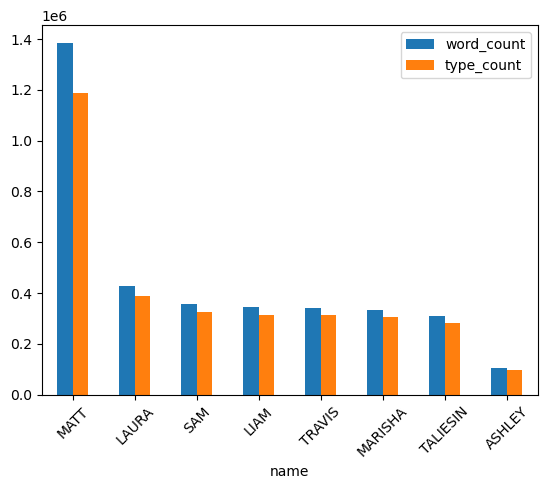

In [22]:
countsdf.set_index(['name']).plot.bar(rot=45)

### Word Length

In [23]:
wlength = cr_df.apply(lambda row: [len(w) for w in (row['nopunc'])], axis=1)
cr_df = cr_df.drop('nopunc', axis=1)

In [24]:
cr_df['avg_word_length'] = wlength.map(sum)/cr_df['word_count']
cr_df['avg_word_length'] = cr_df['avg_word_length'].fillna(0)
cr_df.head()

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,155,"{anybody, in, has, current, online, your, book...",92,3.858065
1,1,LAURA,As in nnnn.,1,00:01:21,,,3,"{nnnn, in, as}",3,2.666667
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,122,"{which, in, this, there, 'beginnings, use, cou...",81,4.180328
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),4,"{you, some, would, like}",4,4.000000
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,129,"{work, in, more, happen, there, ways, want, al...",78,3.899225


In [25]:
cr_df['avg_word_length'].describe()

count    434050.000000
mean          3.692912
std           1.235581
min           0.000000
25%           3.125000
50%           3.666667
75%           4.136364
max          31.000000
Name: avg_word_length, dtype: float64

In [26]:
cr_df[cr_df['avg_word_length']==31] #longest

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length
304806,758,SAM,You-can-respond-to-this-message.,63,01:11:18,,(quickly),1,{you-can-respond-to-this-message},1,31.0


In [27]:
cr_df[cr_df['avg_word_length']==26] #second longest

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length
18042,1603,SAM,dwarvenforge.com/wildlands.,104,02:07:44,,,1,{dwarvenforge.com/wildlands},1,26.0
412361,1903,LIAM,Ch-ch-ch-ch-ch-ch-ch-ch-ch.,94,01:37:24,,,1,{ch-ch-ch-ch-ch-ch-ch-ch-ch},1,26.0


Interesting! I guess NLTK thinks of a hyphen as part of a compound word and counts it only as one long word?
I contemplated correcting this line to separate into multiple words, but I'm not sure I want to really do that. It's written this way to convey the way Sam spoke it - in a rush, mumbled together all as one word. Auditorily speaking, I *do* think it counts as one word. 

### Sentences and sentence length

In [28]:
sents = cr_df.speech_turn.map(nltk.sent_tokenize)
sents[0]   #we can take a look at that full opening speech

["We've got some cool stuff to talk about.",
 'First and foremost, we have two sponsors tonight.',
 "Our first sponsor-- and we're going into, for a time, a cool partnership with the folks at DnD Beyond, actually.",
 "They've been really awesome, and we've been talking, and anybody who hasn't seen it, it's an online digital tool where you can create your own D&D character, they have options to purchase any of the current D&D books out there, and then carry over any of the character options and racial options over into it, so you can basically use it as a tool.",
 "We'll be using it to help us out in the game as we go, 'cause it's actually got some pretty cool stuff.",
 'So excited about that.',
 "It is D-N-D Beyond, by the way, if you haven't seen, not the ampersand.",
 "It's D-N-D."]

In [29]:
sentlength = sents.map(len)    #number of sentences spoken per line
sentlength

0         8
1         1
2         9
3         1
4         8
         ..
434047    1
434048    1
434049    1
434050    0
434051    0
Name: speech_turn, Length: 434050, dtype: int64

In [30]:
avgsentlength = cr_df.word_count/sentlength    #avg length of sentence per line or speech event
avgsentlength

0         19.375000
1          3.000000
2         13.555556
3          4.000000
4         16.125000
            ...    
434047     9.000000
434048     4.000000
434049     1.000000
434050          NaN
434051          NaN
Length: 434050, dtype: float64

In [31]:
cr_df['avg_sent_length']=avgsentlength
cr_df['avg_sent_length'] = cr_df['avg_sent_length'].fillna(0)
cr_df['avg_sent_length'] = cr_df['avg_sent_length'].map("{:.2f}".format)
cr_df['avg_sent_length'] = cr_df['avg_sent_length'].map(float)
cr_df.head()

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length,avg_sent_length
0,0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15,,,155,"{anybody, in, has, current, online, your, book...",92,3.858065,19.38
1,1,LAURA,As in nnnn.,1,00:01:21,,,3,"{nnnn, in, as}",3,2.666667,3.00
2,2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24,,,122,"{which, in, this, there, 'beginnings, use, cou...",81,4.180328,13.56
3,3,TRAVIS,Would you like some?,1,00:02:04,,(vomiting noises),4,"{you, some, would, like}",4,4.000000,4.00
4,4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07,,,129,"{work, in, more, happen, there, ways, want, al...",78,3.899225,16.12


### Let's investigate

Take a look at some of these sentences

In [32]:
cr_df['avg_sent_length'].describe()

count    434050.000000
mean          6.643455
std           6.456691
min           0.000000
25%           2.500000
50%           5.000000
75%           8.500000
max         116.000000
Name: avg_sent_length, dtype: float64

In [33]:
#LOTS of single word sentences, not surprising!
cr_df[cr_df['avg_sent_length']==1]

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length,avg_sent_length
22,22,LAURA,No.,1,00:06:59,,,1,{no},1,2.0,1.0
47,47,MARISHA,Napster.,1,00:09:09,,,1,{napster},1,7.0,1.0
59,59,MARISHA,Afterwards.,1,00:12:27,,,1,{afterwards},1,10.0,1.0
81,81,MATT,Everyone.,1,00:16:32,,,1,{everyone},1,8.0,1.0
128,128,LIAM,Always.,1,00:25:50,,,1,{always},1,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
434000,2675,"LAURA, TALIESIN, LIAM, MARISHA",Yes.,99,03:45:45,,,1,{yes},1,3.0,1.0
434011,2686,"ASHLEY, LAURA",Ooh!,99,03:46:03,,,1,{ooh},1,3.0,1.0
434041,2716,LAURA,Wow.,99,03:47:20,,,1,{wow},1,3.0,1.0
434042,2717,MARISHA,Wow.,99,03:47:22,,,1,{wow},1,3.0,1.0


In [34]:
#but what about that one long sentence?
cr_df[cr_df['avg_sent_length']==116]

,index,name,speech_turn,episode,timestamp,inaudible_speech,nonspeech,word_count,types,type_count,avg_word_length,avg_sent_length
354187,614,MATT,You spend some time with it on the first night...,78,00:41:55,,,116,"{themselves, exit, false, with, on, and, less,...",71,3.939655,116.0


In [35]:
cr_df.speech_turn[354187]

"You spend some time with it on the first night as you're resting around the fire, the horses are off to the side, and you're a couple of false shots, the bolts themselves, it's weird to try and wedge them both in there, and it becomes less of a firing of two bolts simultaneously more than a single bolt becomes the delivery method, that springs and fires them outward as it releases itself, so it's like a crossbow bolt that doesn't have a tip, instead it has both of the bolas tied back and so when it hits the exit point of the crossbow, it releases it and sends it forward. "

This makes sense to me! Looking into it a bit further it looks like Sam was wanting to make some alterations to his character (Nott)'s crossbow which required a skill check. He rolled a 16 (not bad) and Matt narrated the results of his efforts.

Not surprising that the narrator would narrate at length sometimes!

### Average sentence length per speaker

In [36]:
slen = pd.DataFrame(cr_df.groupby('name').avg_sent_length.mean())
slen = slen.reset_index()
slen['avg_sent_length'] = slen['avg_sent_length'].map("{:.2f}".format)
slen['avg_sent_length'] = slen['avg_sent_length'].map(float)
slen = slen.sort_values('avg_sent_length', ascending=False)

In [37]:
avgsents = slen[slen['name'].isin(['MATT', 'LIAM', 'TALIESIN', 'LAURA', 'TRAVIS', 'MARISHA', 'SAM', 'ASHLEY'])]
avgsents

,name,avg_sent_length
211,MATT,8.60
144,LIAM,6.94
312,TALIESIN,6.58
112,LAURA,6.08
337,TRAVIS,5.71
176,MARISHA,5.62
260,SAM,5.57
16,ASHLEY,5.26


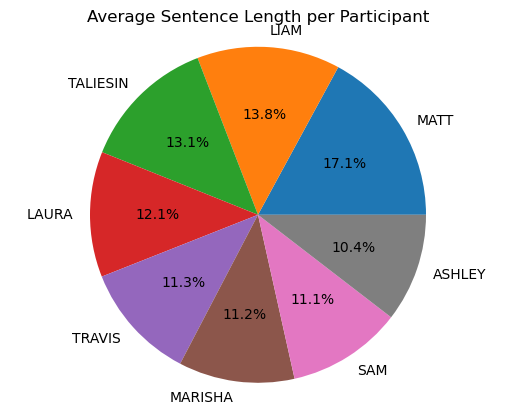

In [38]:
plt.pie(avgsents['avg_sent_length'], labels=avgsents['name'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Average Sentence Length per Participant')
plt.show()

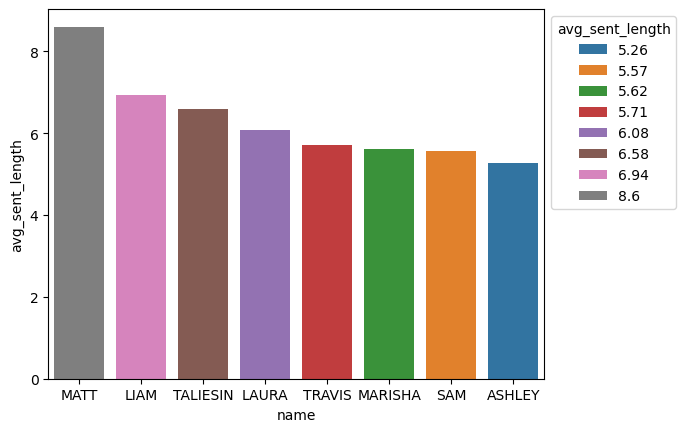

In [39]:
slenplot = sns.barplot(avgsents, x="name", y="avg_sent_length", hue="avg_sent_length", dodge=False)
sns.move_legend(slenplot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

reasonable to do something like avg sentence length of 5+ (to drop instances of single word sentences like "yeah" or "okay") - look into who typically has longer sentences overall. 

also write up an analysis on this too

## Initial Conlusions

djkd

## Dividing the data by group

write about why and what and idk whatever

In [40]:
ashley = pd.DataFrame(cr_df[cr_df['name']=='ASHLEY'])
matt = pd.DataFrame(cr_df[cr_df['name']=='MATT'])
marisha = pd.DataFrame(cr_df[cr_df['name']=='MARISHA'])
taliesin = pd.DataFrame(cr_df[cr_df['name']=='TALIESIN'])
sam = pd.DataFrame(cr_df[cr_df['name']=='SAM'])
liam = pd.DataFrame(cr_df[cr_df['name']=='LIAM'])
laura = pd.DataFrame(cr_df[cr_df['name']=='LAURA'])
travis = pd.DataFrame(cr_df[cr_df['name']=='TRAVIS'])

In [41]:
women = [ashley, marisha, laura]
women_df = pd.concat(women)
women_df['name'].value_counts()

LAURA      59987
MARISHA    49279
ASHLEY     17660
Name: name, dtype: int64

In [42]:
men = [taliesin, sam, liam, travis]
men_df = pd.concat(men)

and the DM data is obviously just..... matt

## Re-measuring

Who is talking more between groups, who says more words, has longer sentences? 

### Lines

In [43]:
#total number of lines/speech events for all women
womenlcount = women_df[['speech_turn']].copy()
womenlcount = womenlcount[womenlcount['speech_turn'] != '']
womenlcount['val'] = 'women'
womenlcount = pd.DataFrame(womenlcount['speech_turn'].groupby(womenlcount['val']).count())
womenlcount = womenlcount.reset_index()
womenlcount['speech_turn']

0    123711
Name: speech_turn, dtype: int64

In [44]:
#total number of lines/speech events for men, not including the DM
menlcount = men_df[['speech_turn']].copy()
menlcount = menlcount[menlcount['speech_turn'] != '']
menlcount['val'] = 'men'
menlcount = pd.DataFrame(menlcount['speech_turn'].groupby(menlcount['val']).count())
menlcount = menlcount.reset_index()
menlcount['speech_turn']

0    178510
Name: speech_turn, dtype: int64

In [45]:
mattlcount = matt[['speech_turn']].copy()
mattlcount = mattlcount[mattlcount['speech_turn'] != '']
mattlcount['val'] = 'DM'
mattlcount = pd.DataFrame(mattlcount['speech_turn'].groupby(mattlcount['val']).count())
mattlcount = mattlcount.reset_index()
mattlcount['speech_turn']

0    109579
Name: speech_turn, dtype: int64

Now, let's keep in mind the *total* lines we already calculated.

In [46]:
#from the beginning of the notebook, blank lines already removed
lcount['speech_turn'].count()

422576

In [47]:
mnw=[womenlcount, menlcount]
dmnw = [womenlcount, menlcount, mattlcount]

mnwlines = pd.concat(mnw)
all_lines = pd.concat(dmnw)

Text(0.5, 1.0, 'Total Lines by Gender (Including DM)')

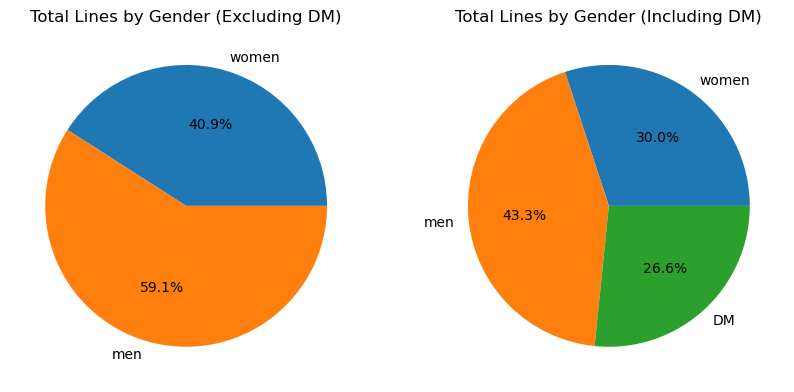

In [48]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwlines['val']
values = mnwlines['speech_turn']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Total Lines by Gender (Excluding DM)')


labels = all_lines['val']
values = all_lines['speech_turn']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Total Lines by Gender (Including DM)')


### % of totals

- Women players (3 people) in Critical Role Campaign 2 contributed **29.3%** of all speech events 
- Men players (4 people) in Critical Role Campaign 2 contributed **42.25%** of all speech events
- Matt, the DM, singularly contributed almost **26%** of all speech events

Men are producing 12.95% more lines than women in total. <br>
Between only men and women, men are producing 18.2% more lines than women<br>
*(keeping in mind again, there is one more man than there are women)*

word count, word length, sent count, sent length, 

### Word Count

In [49]:
womwcount = women_df[['word_count']].copy()
womwcount['val']='women'
womwcount = pd.DataFrame(womwcount['word_count'].groupby(womwcount['val']).sum())
womwcount = womwcount.reset_index()
womwcount.word_count

0    865969
Name: word_count, dtype: int64

In [50]:
menwcount = men_df[['word_count']].copy()
menwcount['val']='men'
menwcount = pd.DataFrame(menwcount['word_count'].groupby(menwcount['val']).sum())
menwcount = menwcount.reset_index()
menwcount.word_count

0    1349707
Name: word_count, dtype: int64

In [51]:
dmwcount = matt[['word_count']].copy()
dmwcount['val']='DM'
dmwcount = pd.DataFrame(dmwcount['word_count'].groupby(dmwcount['val']).sum())
dmwcount = dmwcount.reset_index()
dmwcount.word_count

0    1385768
Name: word_count, dtype: int64

In [52]:
mnwc = [womwcount, menwcount]
dmnwc = [womwcount, menwcount, dmwcount]

mnwcount = pd.concat(mnwc)
dmnwcount = pd.concat(dmnwc)

In [53]:
mnwcount['val'].value_counts()

women    1
men      1
Name: val, dtype: int64

Text(0.5, 1.0, 'Total Words by Gender (Including DM)')

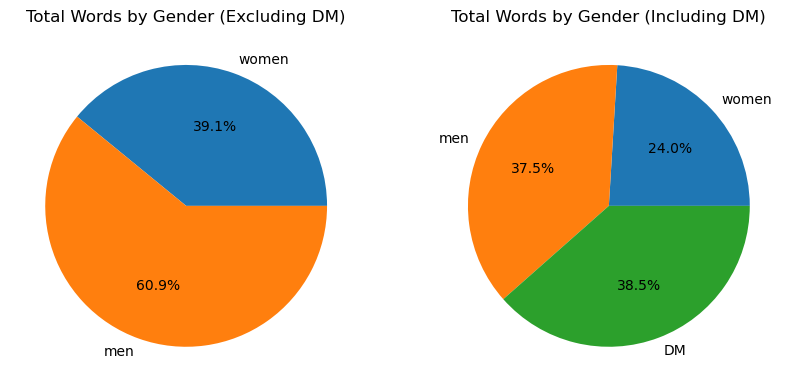

In [54]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwcount['val']
values = mnwcount['word_count']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Total Words by Gender (Excluding DM)')


labels = dmnwcount['val']
values = dmnwcount['word_count']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Total Words by Gender (Including DM)')

Average word lengths were not that interesting, ~3.6 for men and women and ~3.8 for the DM. [This](https://wolfgarbe.medium.com/the-average-word-length-in-english-language-is-4-7-35750344870f) article states that the average word length in the English language is 4.7 characters. CR words on average are pretty short! Not surprising, considering the number of function words being repeated in the data

### Sentence Length

In [55]:
womscount = women_df[['avg_sent_length']].copy()
womscount['val']='women'
womscount = pd.DataFrame(womscount['avg_sent_length'].groupby(womscount['val']).mean())
womscount = womscount.reset_index()
womscount.avg_sent_length

0    5.786185
Name: avg_sent_length, dtype: float64

In [56]:
menscount = men_df[['avg_sent_length']].copy()
menscount['val']='men'
menscount = pd.DataFrame(menscount['avg_sent_length'].groupby(menscount['val']).mean())
menscount = menscount.reset_index()
menscount.avg_sent_length

0    6.139615
Name: avg_sent_length, dtype: float64

In [57]:
mattscount = matt[['avg_sent_length']].copy()
mattscount['val']='DM'
mattscount = pd.DataFrame(mattscount['avg_sent_length'].groupby(mattscount['val']).mean())
mattscount = mattscount.reset_index()
mattscount.avg_sent_length

0    8.596282
Name: avg_sent_length, dtype: float64

In [58]:
dmnws = [womscount, menscount, mattscount]

dmnwslen = pd.concat(dmnws)

<Axes: xlabel='val', ylabel='avg_sent_length'>

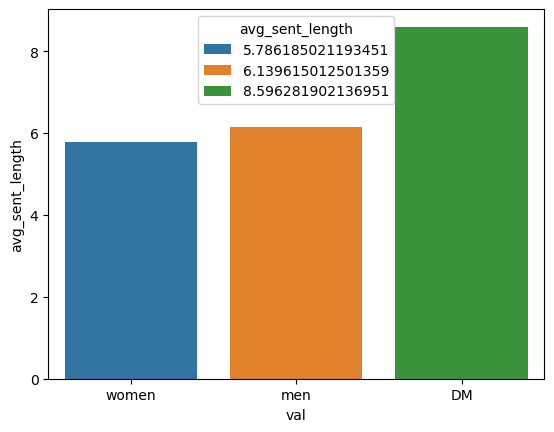

In [59]:
sns.barplot(dmnwslen, x="val", y="avg_sent_length", hue="avg_sent_length", dodge=False)

## Hedging

Phrases to consider

I guess
I think
could be

maybe
might
perhaps
possibly
appears
seems
suggests
tends

In [60]:
matt['speech_turn'].str.count(r'[H|h]ow do you want to do this').sum()

112

## Jargon

In [61]:
jargon = pd.read_pickle('../pickle_jar/jargonlist.pkl') #jargon list as created in PHB_Jargon notebook
jargon[:5]

['tarhun', 'enialis', 'armorsmith', 'himo', 'tieflings']

In [62]:
womlist = women_df['speech_turn'].tolist()
womlist = [w.lower() if isinstance(w, str) else w for w in womlist]
womtoks = [nltk.word_tokenize(s) for s in womlist]
womtoks = list(itertools.chain(*womtoks))

In [63]:
womjarg = [w for w in womtoks if w in jargon]
len(womjarg)

264

In [64]:
menlist = men_df['speech_turn'].tolist()
menlist = [w.lower() if isinstance(w, str) else w for w in menlist]
mentoks = [nltk.word_tokenize(s) for s in menlist]
mentoks = list(itertools.chain(*mentoks))

In [65]:
menjarg = [w for w in mentoks if w in jargon]
len(menjarg)

385

In [66]:
mattlist = matt['speech_turn'].tolist()
mattlist = [w.lower() if isinstance(w, str) else w for w in mattlist]
matttoks = [nltk.word_tokenize(s) for s in mattlist]
matttoks = list(itertools.chain(*matttoks))

In [67]:
mattjarg = [w for w in matttoks if w in jargon]
len(mattjarg)

364

In [68]:
print(womjarg[-10:])
print(menjarg[-10:])
print(mattjarg[-10:])

['revivify', 'revivify', 'revivify', 'cantrips', 'revivify', 'thaumaturgy', 'cantrips', 'revivify', 'revivify', 'tieflings']
['tiefling', 'tharizdun', 'tarrasque', 'agathys', 'agathys', 'cantrip', 'cantrip', 'agathys', 'feywild', 'tiefling']
['cantrip', 'dragonborn', 'shortsword', 'dragonborn', 'agathys', 'cantrip', 'revivify', 'revivify', 'undercommon', 'undercommon']


NameError: name 'mnwslen' is not defined

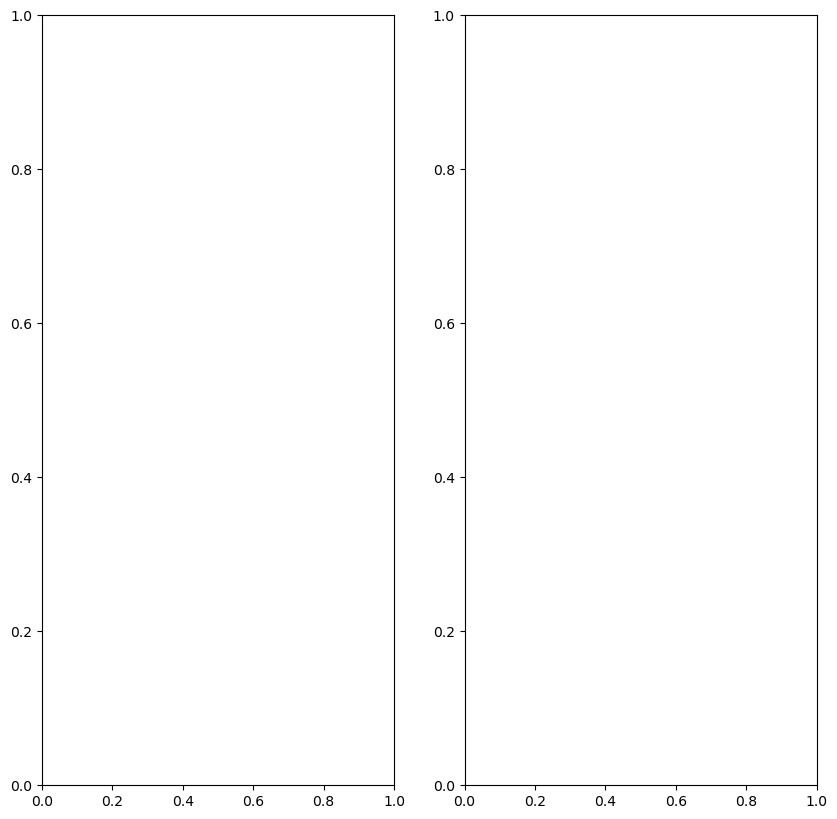

In [69]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwslen['val']
values = mnwslen['avg_sent_length']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Average Sent Length by Gender (Excluding DM)')


labels = dmnwslen['val']
values = dmnwslen['avg_sent_length']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Average Sent Length by Gender (Including DM)')

## Interruptions

In [ ]:
ep2 = cr_df[cr_df['episode']=='2']
ep2[-130:-120]

a link to the moment of chaos, just for comparison - this is a good reference point for chaos and overlapping speech

https://youtu.be/MPELLuQXVcE?si=13too39HcHj5Cfow&t=14475

In [ ]:
travis['speech_turn'].str.count(r'Eldritch Blast').sum()

In [ ]:
liam['speech_turn'].str.count(r'Ja').sum()